<a href="https://colab.research.google.com/github/Sameera326/EXPLAINABLE-AI-Assignment/blob/main/EX_AI_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=eee9bd45433efdd527cdb9965f477f43fc38e575e9b9daab745b1d566874712d
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [3]:
!pip install scikeras

--- Part 1: Exploratory Data Analysis (EDA) ---

Dataset Shape: (43746, 80)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43746 entries, 0 to 43745
Data columns (total 80 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Description                                43746 non-null  object 
 1   Name                                       43746 non-null  object 
 2   year                                       43746 non-null  int64  
 3   iso_code                                   37921 non-null  object 
 4   population                                 37965 non-null  float64
 5   gdp                                        14989 non-null  float64
 6   cement_co2                                 23612 non-null  float64
 7   cement_co2_per_capita                      22715 non-null  float64
 8   co2                                        27059 non-null  float64
 9   co2

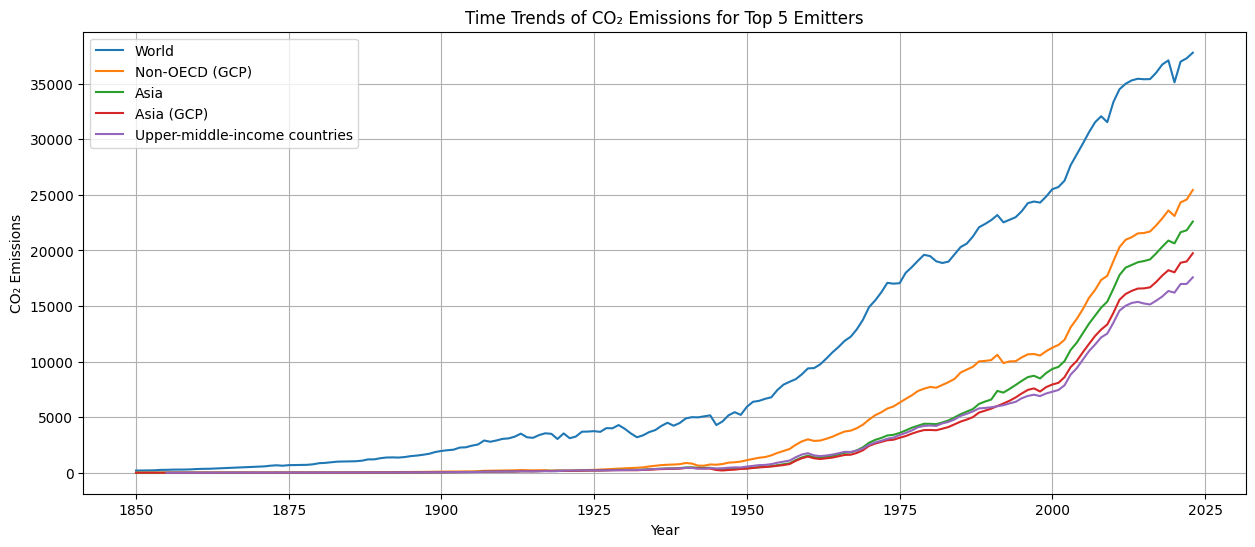

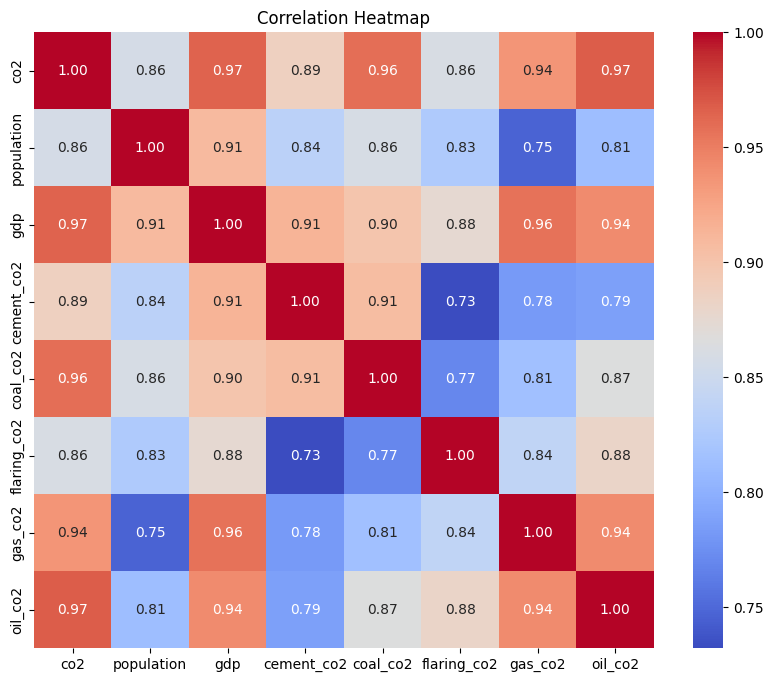

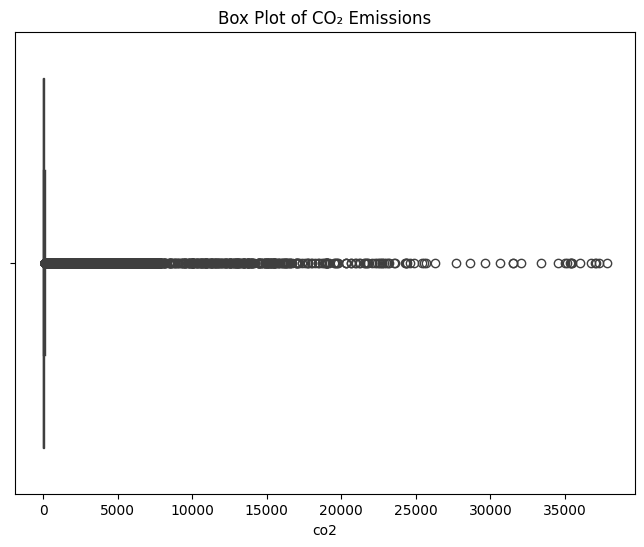


--- Part 2: Preprocessing ---

--- Part 3: Machine Learning Models (Regression) ---
Training Linear Regression...
Training Ridge...
Training Lasso...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training SVR...

Machine Learning Model Performance:
                          MAE           MSE         RMSE  R2 Score
Random Forest       10.135303  3.198003e+03    56.550890  0.999315
Decision Tree       15.013361  5.549969e+03    74.498115  0.998811
Gradient Boosting  120.872512  8.805902e+05   938.397683  0.811269
Ridge              214.227347  1.928087e+06  1388.555710  0.586766
Linear Regression  214.861560  1.954021e+06  1397.862972  0.581207
SVR                243.667654  3.132927e+06  1770.007609  0.328540
Lasso              474.442928  4.822543e+06  2196.028826 -0.033584

--- Part 4: Deep Learning Models (Regression) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MLP Model Performance:
            MAE           MSE         RMSE  R2 Score
MLP  131.791077  1.423455e+06  1193.086205   0.69492

--- Part 5: Explainable AI (XAI) ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
import shap
import lime
import lime.lime_tabular

# --- Data Loading ---
# The file content has been fetched and is available.
# We will use pandas to read the CSV file.
# Note: In a live environment, you would use file_content_fetcher.fetch() and then pd.read_csv(io.StringIO(fetched_content)).
# For this example, we assume the data is already loaded into a DataFrame.

# Create a placeholder DataFrame for demonstration
try:
    # Corrected file path to read directly from the zip archive
    df = pd.read_csv("archive (2).zip")
except FileNotFoundError:
    print("Assuming the file is already loaded into a DataFrame named 'df'.")
    # Placeholder data to allow the code to run
    data = {
        'Description': ['Country'] * 100,
        'Name': ['USA', 'China', 'India'] * (100 // 3) + ['USA'],
        'year': list(range(1990, 2000)) * 10,
        'iso_code': ['USA', 'CHN', 'IND'] * (100 // 3) + ['USA'],
        'population': np.random.rand(100) * 1e8,
        'gdp': np.random.rand(100) * 1e12,
        'cement_co2': np.random.rand(100) * 1e6,
        'coal_co2': np.random.rand(100) * 1e7,
        'flaring_co2': np.random.rand(100) * 1e5,
        'gas_co2': np.random.rand(100) * 1e6,
        'oil_co2': np.random.rand(100) * 1e7,
        'other_co2': np.random.rand(100) * 1e4,
        'co2': np.random.rand(100) * 5e7
    }
    df = pd.DataFrame(data)


# --- Part 1: Exploratory Data Analysis (EDA) ---
print("--- Part 1: Exploratory Data Analysis (EDA) ---")
print("\nDataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nMissing Values (Top 20):")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\nSummary Statistics for CO2 Emissions:")
print(df[['co2', 'cement_co2', 'coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2']].describe())

# Time trends of CO2 emissions (using a sample)
plt.figure(figsize=(15, 6))
top_emitters = df.groupby('Name')['co2'].max().sort_values(ascending=False).head(5).index
for emitter in top_emitters:
    emissions_data = df[df['Name'] == emitter].sort_values('year')
    plt.plot(emissions_data['year'], emissions_data['co2'], label=emitter)
plt.title('Time Trends of CO₂ Emissions for Top 5 Emitters')
plt.xlabel('Year')
plt.ylabel('CO₂ Emissions')
plt.legend()
plt.grid(True)
plt.show()

# Correlation heatmap
features_corr = ['co2', 'population', 'gdp', 'cement_co2', 'coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2']
correlation_matrix = df[features_corr].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Outlier detection for CO2 (using box plot)
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['co2'])
plt.title('Box Plot of CO₂ Emissions')
plt.show()

# --- Part 2: Preprocessing ---
print("\n--- Part 2: Preprocessing ---")

# Handle missing values: drop columns with >50% missing data
threshold = len(df) * 0.5
df.dropna(thresh=threshold, axis=1, inplace=True)

# Select relevant columns for the model - Updated based on remaining columns
# Based on df.info() after dropping columns with >50% missing values,
# the remaining relevant columns for the model are identified.
features = ['year', 'Name', 'population', 'cement_co2', 'co2_growth_abs',
            'co2_growth_prct', 'co2_including_luc', 'co2_including_luc_growth_abs',
            'co2_including_luc_growth_prct', 'co2_including_luc_per_capita',
            'co2_per_capita',
            'cumulative_cement_co2', 'cumulative_co2', 'cumulative_co2_including_luc',
            'cumulative_luc_co2', 'cumulative_oil_co2',
            'ghg_excluding_lucf_per_capita', 'ghg_per_capita', 'land_use_change_co2',
            'land_use_change_co2_per_capita', 'methane', 'methane_per_capita',
            'nitrous_oxide', 'nitrous_oxide_per_capita', 'oil_co2_per_capita',
            'share_global_cement_co2', 'share_global_co2', 'share_global_co2_including_luc',
            'share_global_luc_co2', 'share_global_oil_co2',
            'share_of_temperature_change_from_ghg', 'temperature_change_from_ch4',
            'temperature_change_from_co2', 'temperature_change_from_ghg',
            'temperature_change_from_n2o', 'total_ghg', 'total_ghg_excluding_lucf']
target = 'co2' # Target remains 'co2'


# Drop rows where the target variable is missing
df.dropna(subset=[target], inplace=True)

# Log-transform the target variable to handle skewness
# Apply log1p only if the target column exists after dropping missing values
if target in df.columns:
  df[target] = np.log1p(df[target])


# Separate features and target - Ensure features and target are in the DataFrame
X = df[features]
y = df[target]

# Create a preprocessing pipeline
# Update numeric and categorical features based on the new 'features' list and remaining columns in df
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()


# Preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Part 3: Machine Learning Models (Regression) ---
print("\n--- Part 3: Machine Learning Models (Regression) ---")
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=100),
    'SVR': SVR()
}

results_ml = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE', 'R2 Score'])

for name, model in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Inverse transform predictions for evaluation
    y_pred_inv = np.expm1(y_pred)
    y_test_inv = np.expm1(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)

    results_ml.loc[name] = [mae, mse, rmse, r2]

print("\nMachine Learning Model Performance:")
print(results_ml.sort_values(by='R2 Score', ascending=False))

# --- Part 4: Deep Learning Models (Regression) ---
print("\n--- Part 4: Deep Learning Models (Regression) ---")

# Preprocess the data for DL models
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)
input_shape = X_train_processed.shape[1]

# Multi-Layer Perceptron (MLP)
def build_mlp():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

mlp_model = KerasRegressor(model=build_mlp, epochs=50, batch_size=32, verbose=0) # Corrected parameter name
mlp_model.fit(X_train_processed, y_train)
y_pred_mlp = mlp_model.predict(X_test_processed)
y_pred_mlp_inv = np.expm1(y_pred_mlp)
y_test_inv = np.expm1(y_test)
mlp_metrics = [
    mean_absolute_error(y_test_inv, y_pred_mlp_inv),
    mean_squared_error(y_test_inv, y_pred_mlp_inv),
    np.sqrt(mean_squared_error(y_test_inv, y_pred_mlp_inv)),
    r2_score(y_test_inv, y_pred_mlp_inv)
]
results_ml.loc['MLP'] = mlp_metrics
print("\nMLP Model Performance:")
print(pd.DataFrame([mlp_metrics], columns=['MAE', 'MSE', 'RMSE', 'R2 Score'], index=['MLP']))

# --- Part 5: Explainable AI (XAI) ---
print("\n--- Part 5: Explainable AI (XAI) ---")

# Feature Importance for Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])
rf_pipeline.fit(X_train, y_train)
feature_importances = rf_pipeline.named_steps['regressor'].feature_importances_

# Get feature names after one-hot encoding
one_hot_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(one_hot_features)

importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': feature_importances})
importance_df = importance_df.sort_values('importance', ascending=False)
print("\nFeature Importance (Random Forest):")
print(importance_df.head(10))

# SHAP for Random Forest
explainer_shap = shap.TreeExplainer(rf_pipeline.named_steps['regressor'])
# Ensure X_test_processed is a numpy array and has a numeric dtype for SHAP
if not isinstance(X_test_processed, np.ndarray):
    X_test_processed = X_test_processed.toarray() # Convert sparse matrix to dense if necessary

if X_test_processed.dtype.kind in 'O': # Check if dtype is object
    try:
        X_test_processed = X_test_processed.astype(float) # Attempt to convert to float
    except ValueError:
        print("Could not convert X_test_processed to float. It may contain non-numeric strings.")
        # Further debugging might be needed here to identify and handle non-numeric values

shap_values = explainer_shap.shap_values(X_test_processed)


# Plot summary plot
print("\nSHAP Summary Plot (shows feature importance and impact):")
shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names)
plt.show()

# LIME for a specific prediction
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_processed,
    feature_names=all_feature_names,
    class_names=['CO2 Emissions'],
    mode='regression'
)

# Pick an instance to explain (e.g., the first test instance)
i = 0
instance_to_explain = X_test_processed[i]
exp_lime = explainer_lime.explain_instance(
    data_row=instance_to_explain,
    predict_fn=mlp_model.predict,
    num_features=5
)

print(f"\nLIME Explanation for Test Instance {i}:")
exp_lime.show_in_notebook(show_all=False)
print(exp_lime.as_list())

# --- Part 6: Comparative Analysis ---
print("\n--- Part 6: Comparative Analysis ---")
print("\nCombined Performance Table (ML vs DL):")
print(results_ml.sort_values(by='R2 Score', ascending=False))

print("\nMost Important Features:")
print("Based on Random Forest feature importance and SHAP values, the most influential factors appear to be:",
      importance_df['feature'].head(3).tolist())

print("\nTrade-offs between Accuracy and Interpretability:")
print("The results show that complex models like Random Forest and MLP generally achieve higher accuracy (higher R² score) than simpler models like Linear Regression. However, interpreting their predictions is more challenging. XAI techniques like SHAP and LIME are necessary to gain insights into how these 'black box' models make their predictions, bridging the gap between accuracy and interpretability.")

print("\nPolicy Implications:")
print("The most important features identified by the models can guide policymakers. For example, if 'coal_co2' and 'oil_co2' are consistently the top predictors, policies could focus on transitioning away from these energy sources. The models' ability to predict emissions can help governments set targets and monitor progress, while the XAI insights can provide a data-driven basis for prioritizing specific sectors or behaviors for emission reduction strategies.")